In [1]:
import warp
# warp.config.mode = "debug"
warp.config.verify_cuda = True

In [1]:
import warp
from typing import Any


@warp.kernel
def untile_image_kernel(
    # tiled_image: warp.array(dtype=warp.uint8),      # shape: (H, W, C)
    # batched_image: warp.array(dtype=warp.uint8),    # shape: (N, H_tile, W_tile, C)
    tiled_image: Any,      # shape: (H, W, C)
    batched_image: Any,    # shape: (N, H_tile, W_tile, C)
    tile_height: int,                           # H_tile
    tile_width: int,                            # W_tile
    num_channels: int,                          # C
    num_tiles_x: int,                           # tiles per row
):
    """
    Kernel: given a tiled image (H, W, C), write tiles into (N, H_tile, W_tile, C).

    Launch with dim = (N, H_tile, W_tile).
    """

    tile_id, ty, tx = warp.tid()  # (n, h_tiled, w_tiled)

    # which tile in the grid
    tile_x = tile_id % num_tiles_x
    tile_y = tile_id // num_tiles_x

    # source pixel coords in the big tiled image
    src_y = tile_y * tile_height + ty
    src_x = tile_x * tile_width + tx

    for c in range(num_channels):
        batched_image[tile_id, ty, tx, c] = tiled_image[src_y, src_x, c]


def untile_image(
    tiled_image: warp.array,
    shape: tuple[int, int, int],
    device: str | None = None,
    stream: warp.Stream | None = None,
) -> warp.array:
    """
    Wrapper: given a tiled image with conceptual shape (H, W, C),
    return tiles with shape (N, H_tile, W_tile, C).

    Args:
        tiled_image: warp.array with shape (H, W, C), dtype=uint8.
        tile_height: height of each tile (H_tile).
        tile_width: width of each tile (W_tile).
        device: optional Warp device; defaults to tiled_image.device.
        stream: optional Warp stream.

    Returns:
        batched_image: warp.array with shape (N, H_tile, W_tile, C).
    """


    height, width, num_channels = tiled_image.shape
    num_tiles, tile_height, tile_width = shape
    num_tiles_x = width // tile_width

    if device is None:
        device = tiled_image.device

    # allocate output: (N, H_tile, W_tile, C)
    batched_image = warp.empty(
        shape=(num_tiles, tile_height, tile_width, num_channels),
        dtype=tiled_image.dtype,
        device=device,
    )

    # launch kernel
    warp.launch(
        kernel=untile_image_kernel,
        dim=(num_tiles, tile_height, tile_width),
        inputs=[
            tiled_image,
            batched_image,
            tile_height,
            tile_width,
            num_channels,
            num_tiles_x,
        ],
        device=device,
        stream=stream,
    )

    return batched_image


In [ ]:
# TODO
def test_untile_image():
    pass

In [49]:
import numpy
import warp


num_channels = 4
num_width_repeats, num_height_repeats = 3, 3
num_tiles, width_tile, height_tile = 9, 4, 4
num_tiles_to_untile = 9

num_channels = 4
num_width_repeats, num_height_repeats = 3, 2
num_tiles, width_tile, height_tile = 9, 5, 4
num_tiles_to_untile = 2

tile_expected = (
    numpy.arange(width_tile * height_tile * num_channels)
    .reshape((width_tile, height_tile, num_channels))
)

todo = numpy.tile(
    tile_expected,
    reps=(num_width_repeats, num_height_repeats, 1),
)
todo_tiled = untile_image(
    warp.array(todo), 
    (num_tiles_to_untile, width_tile, height_tile),
)
batch_tiled_actual = warp.to_torch(todo_tiled).cpu().numpy()


for tiled_actual in batch_tiled_actual:
    numpy.testing.assert_equal(actual=tiled_actual, desired=tile_expected)

In [ ]:
# TODO num_tiles_to_untile

In [25]:
import einops
import numpy


num_tiles_height = 2
num_tiles_width = 2
num_channels = 4
height_tile, width_tile = 4, 4


num_tiles_height = 3
num_tiles_width = 4
num_channels = 4
height_tile, width_tile = 1280, 720

batch_image_expected = numpy.random.randint(
    0, 255,
    size=(
        num_tiles_height * num_tiles_width,
        height_tile,
        width_tile,
        num_channels,
    ),
)
tiled_image_todo = einops.rearrange(
    batch_image_expected, 
    "(num_tiles_height num_tiles_width) height width channel -> (num_tiles_height height) (num_tiles_width width) channel", 
    num_tiles_height=num_tiles_height,
    num_tiles_width=num_tiles_width,
)

for num_tiles_to_untile in range(num_tiles_height * num_tiles_width):
    batch_image_actual = untile_image(
        warp.array(tiled_image_todo), 
        (num_tiles_to_untile, height_tile, width_tile),
    )
    batch_image_actual = warp.to_torch(batch_image_actual).cpu().numpy()

    numpy.testing.assert_equal(actual=batch_image_actual[:num_tiles_to_untile], desired=batch_image_expected[:num_tiles_to_untile])

In [26]:
a = warp.array(tiled_image_todo)
a.device

'cuda:0'

In [48]:
%%timeit -n 100
untile_image(
        a, 
        (num_tiles_to_untile, height_tile, width_tile),
    )

60.4 μs ± 25.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
%%timeit -n 100

warp.to_torch(a)

4.45 μs ± 2.68 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
import torch

a_torch = torch.asarray(tiled_image_todo).cuda()


In [49]:
%%timeit -n 100

einops.rearrange(
    a_torch, 
    "(num_tiles_height height) (num_tiles_width width) channel -> (num_tiles_height num_tiles_width) height width channel", 
    num_tiles_height=num_tiles_height,
    num_tiles_width=num_tiles_width,
)

12.4 μs ± 2.43 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
batch_image_expected[3:].shape

(1, 4, 4, 4)

In [ ]:
import warp

import numpy


todo = numpy.tile(
    numpy.arange(4 * 4 * 1).reshape((4, 4, 1)).astype(numpy.uint8),
    reps=(3, 3, 1),
)
todo_tiled = untile_image(
    warp.array(todo),
    (9, 4, 4),
)

array([[[ 0],
        [ 1],
        [ 2],
        [ 3]],

       [[ 4],
        [ 5],
        [ 6],
        [ 7]],

       [[ 8],
        [ 9],
        [10],
        [11]],

       [[12],
        [13],
        [14],
        [15]]])

In [33]:
print(todo_tiled[0])

[[[ 0]
  [ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]
  [ 7]]

 [[ 8]
  [ 9]
  [10]
  [11]]

 [[12]
  [13]
  [14]
  [15]]]


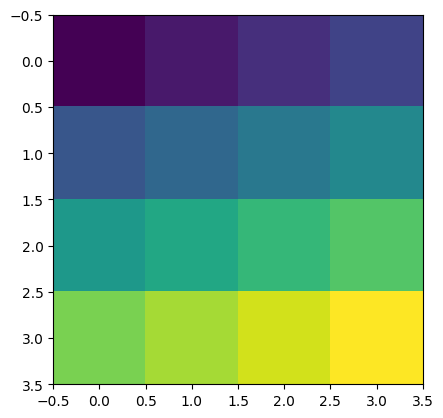

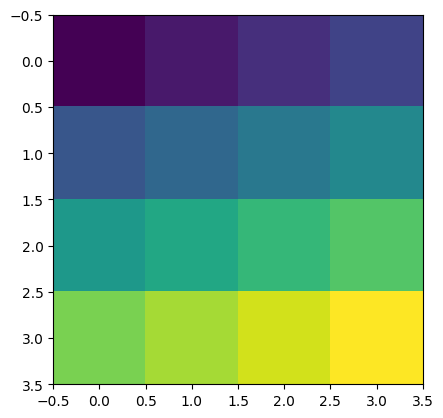

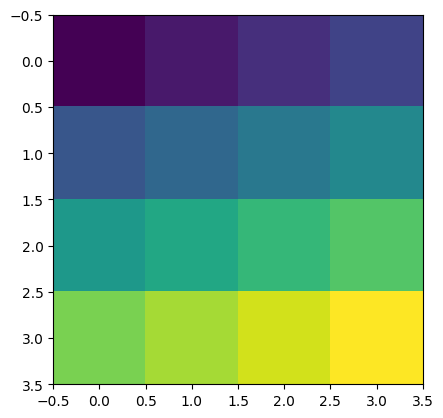

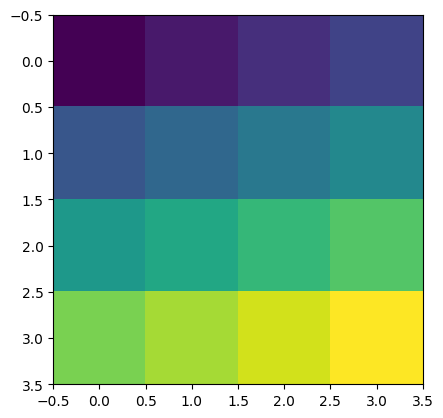

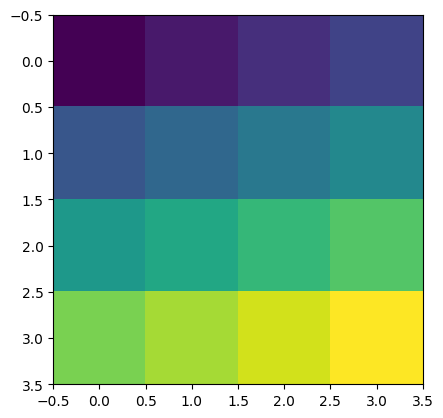

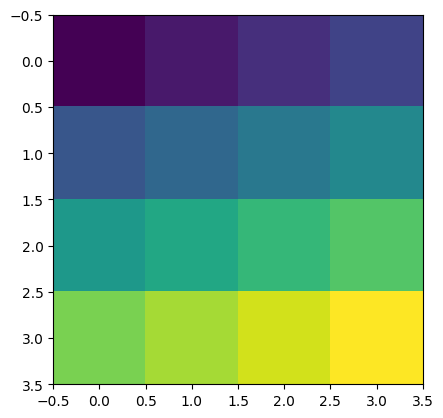

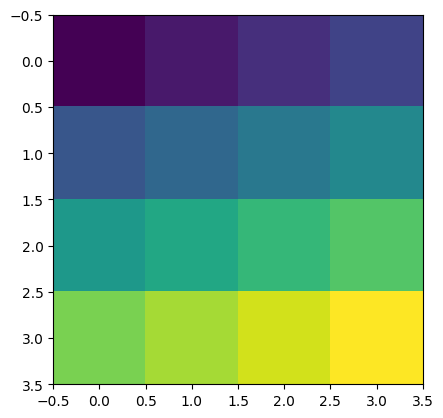

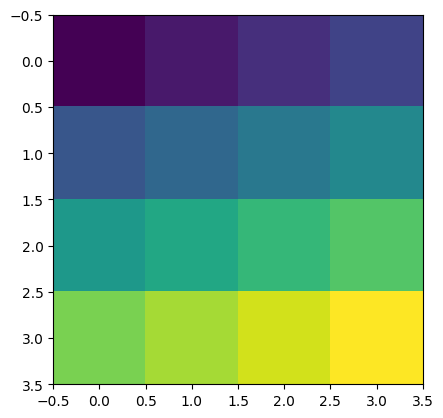

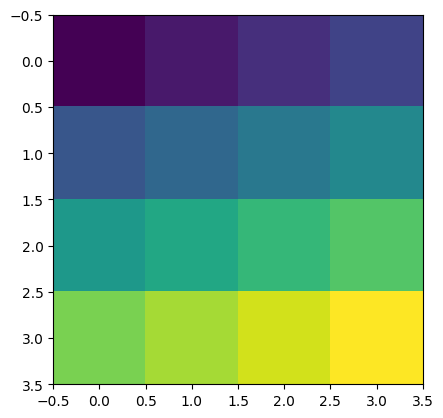

In [34]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.imshow(warp.to_torch(todo_tiled).cpu().numpy()[i] / numpy.max(todo))
    plt.show()



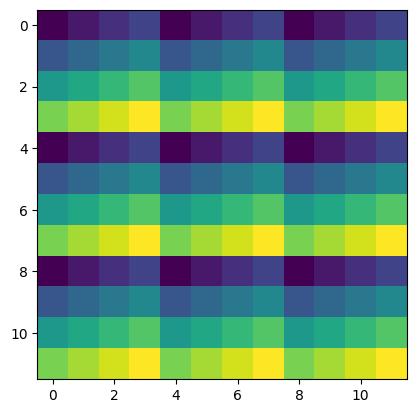

In [35]:
import matplotlib.pyplot as plt

plt.imshow(todo / numpy.max(todo))

In [ ]:


import numpy


todo = numpy.tile(
    numpy.arange(4 * 4 * 1).reshape((4, 4, 1)).astype(numpy.uint8),
    reps=(3, 3, 1),
)

import warp
from robotodo.engines.isaac.sensor import _reshape_tiled_image


todo_tiled = _reshape_tiled_image(
    warp.array(todo),
    shape=(9, 4, 4, 1),
)

Warp 1.8.1 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "CPU"
     "cuda:0"   : "NVIDIA GeForce RTX 3090" (24 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/sysadmin/.cache/warp/1.8.1
TODO rm _reshape_tiled_image (12, 12, 1) (9, 4, 4, 1)
Module robotodo.engines.isaac.sensor f8aacaa load on device 'cuda:0' took 0.82 ms  (cached)


In [3]:
numpy.arange(4 * 4 * 1).reshape((4, 4, 1)).astype(numpy.uint8)

array([[[ 0],
        [ 1],
        [ 2],
        [ 3]],

       [[ 4],
        [ 5],
        [ 6],
        [ 7]],

       [[ 8],
        [ 9],
        [10],
        [11]],

       [[12],
        [13],
        [14],
        [15]]], dtype=uint8)

In [4]:
0 % 3, 0 // 3

(0, 0)

In [5]:
todo

array([[[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 0],
        [ 1],
        [ 2],
        [ 3]],

       [[ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 4],
        [ 5],
        [ 6],
        [ 7]],

       [[ 8],
        [ 9],
        [10],
        [11],
        [ 8],
        [ 9],
        [10],
        [11],
        [ 8],
        [ 9],
        [10],
        [11]],

       [[12],
        [13],
        [14],
        [15],
        [12],
        [13],
        [14],
        [15],
        [12],
        [13],
        [14],
        [15]],

       [[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 0],
        [ 1],
        [ 2],
        [ 3]],

       [[ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 4],
        [ 5],
        [ 

In [6]:
todo.flatten()

array([ 0,  1,  2,  3,  0,  1,  2,  3,  0,  1,  2,  3,  4,  5,  6,  7,  4,
        5,  6,  7,  4,  5,  6,  7,  8,  9, 10, 11,  8,  9, 10, 11,  8,  9,
       10, 11, 12, 13, 14, 15, 12, 13, 14, 15, 12, 13, 14, 15,  0,  1,  2,
        3,  0,  1,  2,  3,  0,  1,  2,  3,  4,  5,  6,  7,  4,  5,  6,  7,
        4,  5,  6,  7,  8,  9, 10, 11,  8,  9, 10, 11,  8,  9, 10, 11, 12,
       13, 14, 15, 12, 13, 14, 15, 12, 13, 14, 15,  0,  1,  2,  3,  0,  1,
        2,  3,  0,  1,  2,  3,  4,  5,  6,  7,  4,  5,  6,  7,  4,  5,  6,
        7,  8,  9, 10, 11,  8,  9, 10, 11,  8,  9, 10, 11, 12, 13, 14, 15,
       12, 13, 14, 15, 12, 13, 14, 15], dtype=uint8)

In [7]:
print(todo_tiled[0])

[[[ 0]
  [ 1]
  [ 2]
  [ 3]]

 [[ 0]
  [ 1]
  [ 2]
  [ 3]]

 [[ 0]
  [ 1]
  [ 2]
  [ 3]]

 [[12]
  [13]
  [14]
  [15]]]


In [8]:
warp.array(todo).shape

(12, 12, 1)

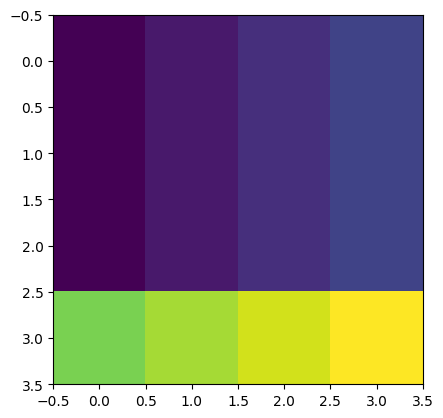

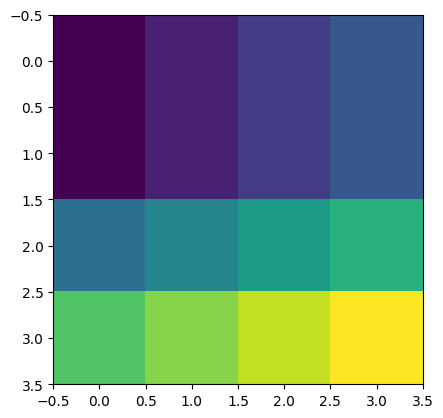

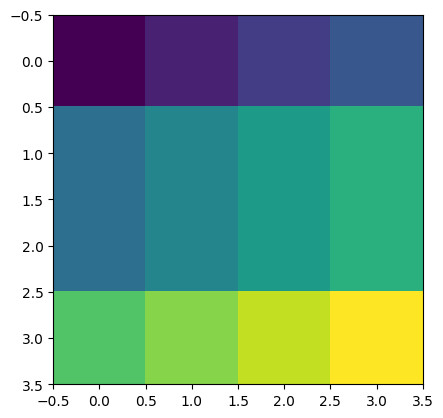

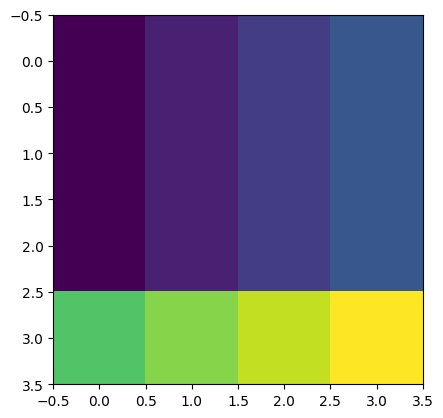

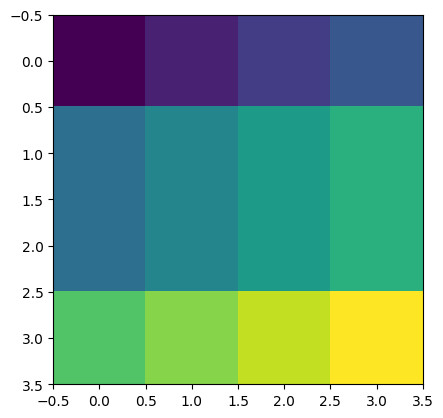

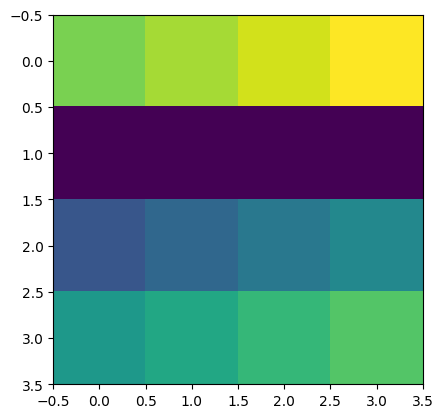

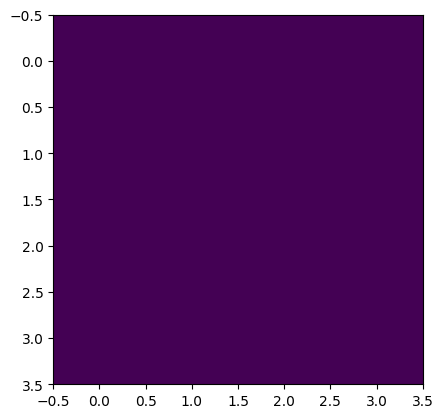

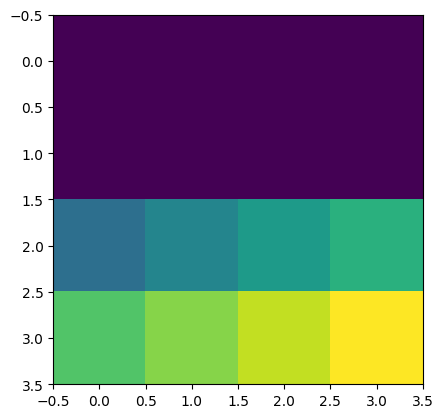

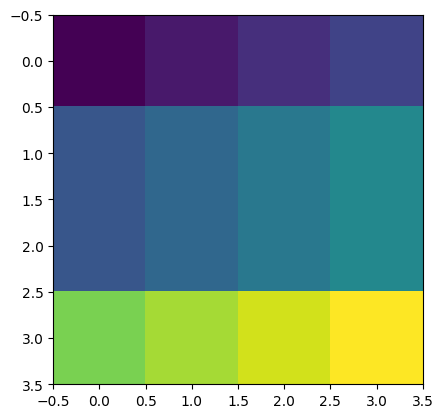

In [12]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.imshow(warp.to_torch(todo_tiled).cpu().numpy()[i] / numpy.max(todo))
    plt.show()



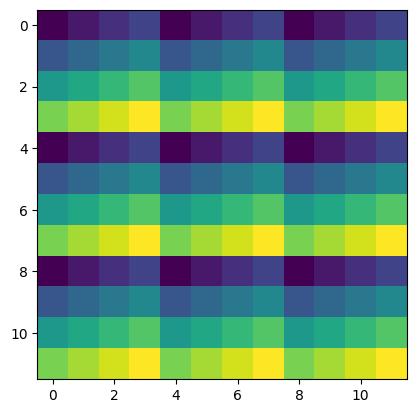

In [10]:
import matplotlib.pyplot as plt

plt.imshow(todo / numpy.max(todo))

In [29]:
numpy.arange(2 * 4 * 3).reshape((2, 4, 3))

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]]])

In [20]:
todo.shape

(6, 12, 3)

In [19]:
print(todo)

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]
  [12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]
  [12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]]

 [[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]
  [12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]
  [12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]]

 [[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]
  [12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]
  [12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]]]


In [2]:
warp.empty((10, 10, 3)).device

Warp 1.8.1 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "CPU"
     "cuda:0"   : "NVIDIA GeForce RTX 3090" (24 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/sysadmin/.cache/warp/1.8.1


'cuda:0'

In [3]:
warp.empty((256, 512, 4))

array(shape=(256, 512, 4), dtype=float32)

In [4]:
from robotodo.engines.isaac.sensor import _reshape_tiled_image


arr = _reshape_tiled_image(
    # warp.empty((256, 512, 4), dtype=warp.uint8),
    warp.empty((512, 256, 4)),
    shape=(2, 256, 256, 4),
)
print(arr)



TODO rm _reshape_tiled_image (512, 256, 4) (2, 256, 256, 4)
Module robotodo.engines.isaac.sensor e7a011f load on device 'cuda:0' took 2.87 ms  (cached)
[[[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  ...

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [

In [52]:

def _get_tiled_resolution(num_cameras, resolution):
    """Calculate the resolution for the tiled sensor based on the number of cameras and individual camera resolution.

    Args:
        num_cameras (int): Total number of cameras.
        resolution (Tuple[int, int]): Resolution of each individual camera.

    Returns:
        Tuple[int, int]: The total resolution for the tiled sensor layout.
    """
    num_rows = round(num_cameras**0.5)
    num_columns = (num_cameras + num_rows - 1) // num_rows

    return (num_columns * resolution[0], num_rows * resolution[1])


_get_tiled_resolution(3, (256, 256))

(512, 512)

In [6]:
import torch
torch.empty((256, 512, 4), device="cuda").device

device(type='cuda', index=0)

In [15]:
%%timeit -n 10

arr = _reshape_tiled_image(
    warp.empty((10, 10, 3)),
    shape=(1, 10, 10, 3),
)

TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10, 10, 3)
TODO rm _reshape_tiled_image (10, 10, 3) (1, 10,

In [5]:

import numpy
import matplotlib.pyplot as plt


warp.to_torch(arr)

tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]], device='cuda:0')